# source: Ocean Tracking Network

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://cyborgsealsfor.science:8443/erddap',
    protocol='tabledap',
)

In [2]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))


print(
    f'We have {len(set(df["tabledap"].dropna()))} tabledap,'
    f'{len(set(df["griddap"].dropna()))} griddap,'
    f'and {len(set(df["wms"].dropna()))} wms endpoints.'
)

We have 3 tabledap,0 griddap,and 0 wms endpoints.


In [3]:
e.dataset_id = 'locations'

locations = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

locations.head()

,ptt,longitude,latitude,argos_quality
time,,,,
2015-03-27 12:52:27,110448,-63.038,41.928,1
2015-03-27 13:44:32,110448,-63.037,41.933,B
2015-03-27 14:34:59,110448,-63.021,41.957,2
2015-03-27 15:20:02,110448,-62.999,41.962,2
2015-03-27 16:09:27,110448,-62.995,41.976,1


In [4]:
e.dataset_id = 'sensors'

sensors = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

sensors.head()

,ptt,temperature,trange,drange,depth
time,,,,,
2014-09-29 08:00:00,110451,17.0,0.5,3.0,26.5
2014-09-29 08:10:00,110451,17.0,0.5,3.0,17.0
2014-09-29 08:20:00,110451,17.0,0.5,3.0,17.0
2014-09-29 08:30:00,110451,17.0,0.5,3.0,12.0
2014-09-29 08:40:00,110451,17.0,0.5,3.0,26.5


# The sensor data does seem seem to match the locations :-/

In [5]:
locations.index[0], locations.index[1]

(Timestamp('2015-03-27 12:52:27'), Timestamp('2015-03-27 13:44:32'))

In [6]:
sensors.index[0], sensors.index[1]

(Timestamp('2014-09-29 08:00:00'), Timestamp('2014-09-29 08:10:00'))

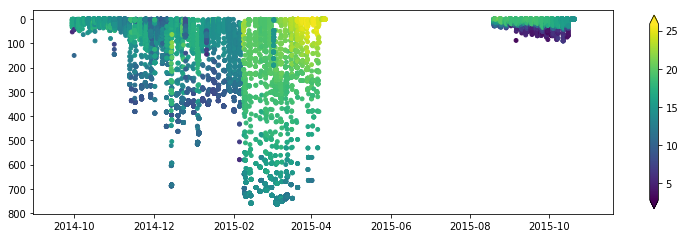

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(13, 3.75))
cs = ax.scatter(sensors.index, sensors['depth'], s=15, c=sensors['temperature'])
fig.colorbar(cs, orientation='vertical', shrink=0.95, extend='both')
ax.invert_yaxis()

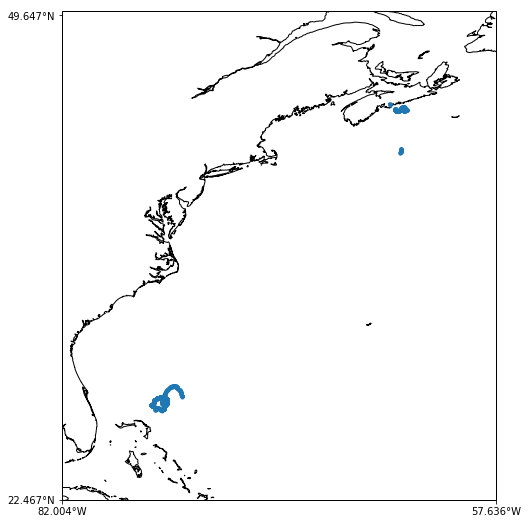

In [8]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(extent):
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution='10m')
    ax.set_extent(extent)

    ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
    ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


dx = dy = 5
extent = (
    locations['longitude'].min() - dx,
    locations['longitude'].max() + dx,
    locations['latitude'].min() - dy,
    locations['latitude'].max() + dy,
)

kw = {'marker': '.', 'linestyle': 'none'}

fig, ax = make_map(extent)
ax.plot(locations['longitude'], locations['latitude'], **kw);

In [9]:
points = []

for date, point in list(locations.iterrows()):
    date = date.strftime('%Y-%m-%dT%H:%M')
    coordinates = point['longitude'], point['latitude']
    points.append(
        {
            'coordinates': coordinates,
            'dates': date,
        },
    )


features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': point['coordinates'],
        },
        'properties': {
            'time': point['dates'],
            'icon':'marker',
            'id': 'house',
            'iconstyle':{
                'iconUrl': 'http://downloadicons.net/sites/default/files/Animals-Shark-Icon-738718.png',
                'iconSize':     [20, 20]
            }
        }
    }
    for point in points
]

In [10]:
import folium
from folium.plugins import Fullscreen, TimestampedGeoJson


tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/Ocean_Basemap/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri'

m = folium.Map(tiles=tiles, attr=attr)

Fullscreen(force_separate_button=True).add_to(m)

TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features,
    },
    period='P1D',
    add_last_point=True,
).add_to(m)


m.fit_bounds(m.get_bounds())

m